## Pond dissolved oxygen prediction

This notebook starts a series of efforts to predict DO in aquaculture ponds.

Here, the goal is to predict DO utilizing solely DO data. Measurements were taken twice daily, during the morning and evening, aligning closely with sunrise and sunset timings (with a variance of +/- one hour).

TLDR: The model accurately captures the overarching trends, presenting an error (RMSE) ranging from 0.8 to 2. It performs well, especially when the data remains relatively stable. However, during episodes of heightened DO fluctuations, particularly those caused by liming or the introduction of manure (which exerts a substantial oxygen demand), the model struggles to adapt.

Scroll to the bottom to see predicted vs real data graphs.

A SARIMA model will be used. SARIMA, or Seasonal Autoregressive Integrated Moving Average, is a forecasting method that analyzes time-based data by considering its past values (autoregressive), handling trends and irregularities (integrated), and factoring in past forecast errors (moving average). It extends its capabilities by accounting for repeating patterns over specific intervals, like seasons. By combining these components, SARIMA can provide accurate predictions for future data points, making it a valuable tool for understanding and forecasting various cyclic phenomena.

In [19]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt

# Load the data. One pd series with DO values (o2) for each pond.
pond_names = ['np1', 'np2', 'vp1', 'vp2', 'vp3', 'vp4']
o2_series = {}
print('Loading data. One pd series with DO values (o2) for each pond.')
for pond_name in pond_names:
    o2_series[pond_name] = pd.read_csv('o2_only_ponds/'+pond_name+'_series.csv')['o2']
    print(f'pond: {pond_name}, entries: {len(o2_series[pond_name])}')

Loading data. One pd series with DO values (o2) for each pond.
pond: np1, entries: 150
pond: np2, entries: 150
pond: vp1, entries: 126
pond: vp2, entries: 126
pond: vp3, entries: 126
pond: vp4, entries: 126


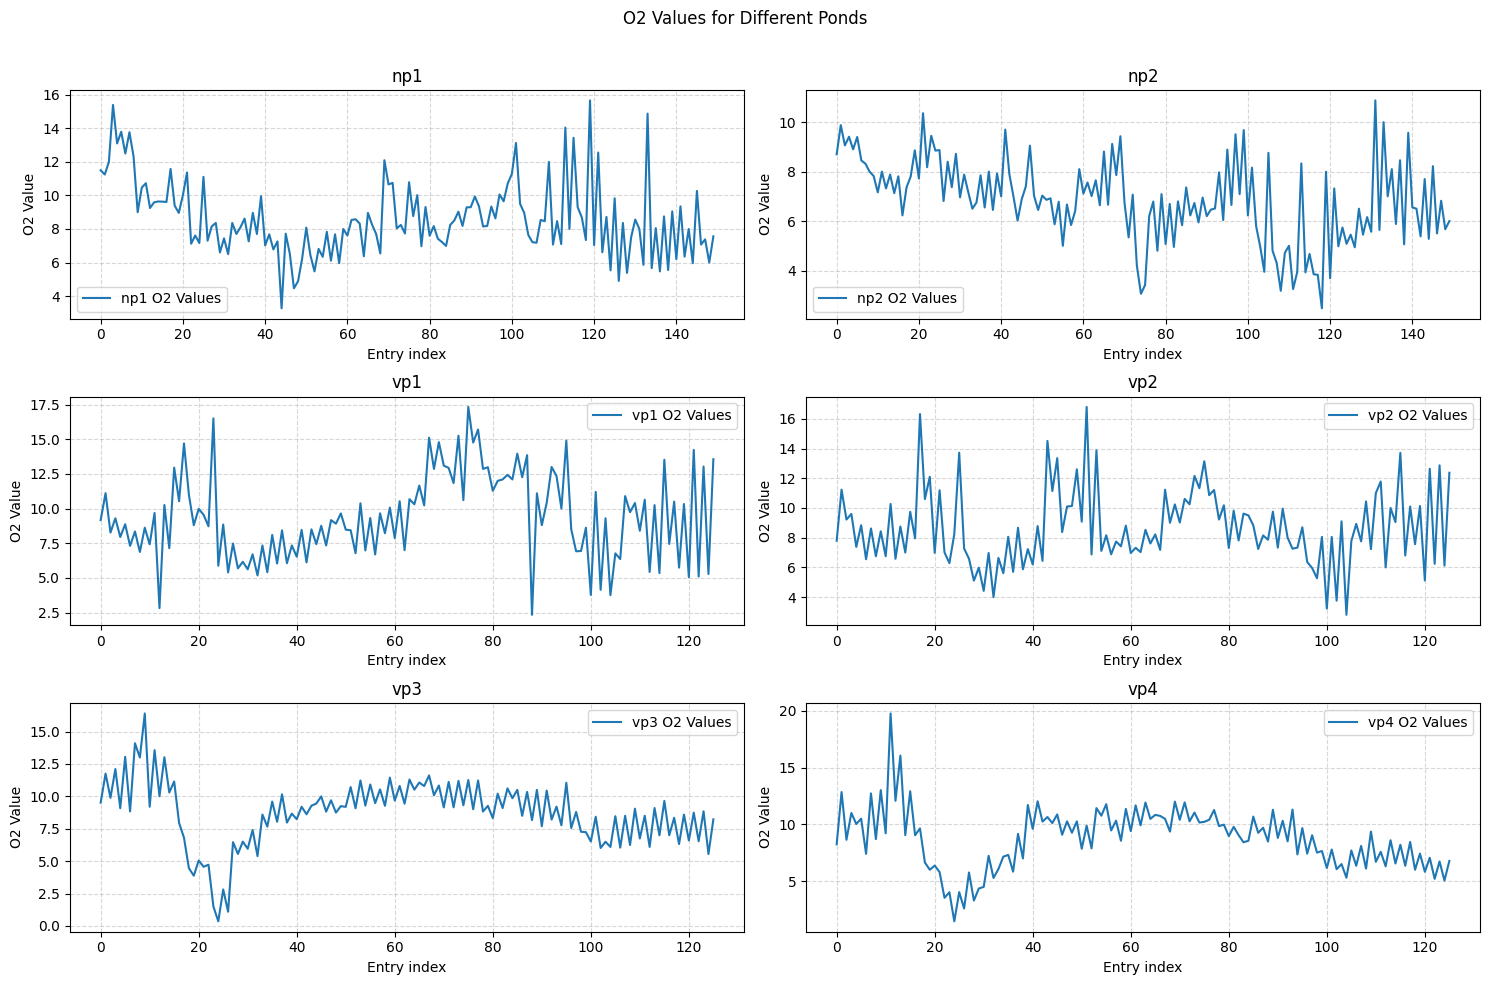

In [20]:
# Creating a 2x3 grid for the ponds (2 rows, 3 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('O2 Values for Different Ponds')

# Flatten the axes array for easier indexing
axes = axes.ravel()

for idx, pond_name in enumerate(pond_names):
    # Plotting the O2 values for each pond
    axes[idx].plot(o2_series[pond_name], label=f'{pond_name} O2 Values')
    axes[idx].set_title(pond_name)
    axes[idx].set_xlabel('Entry index')
    axes[idx].set_ylabel('O2 Value')
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.5)

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust the top spacing so that the main title doesn't overlap
plt.show()


In [21]:
for pond_name in o2_series.keys():
    ser = o2_series[pond_name]
    print(f'pond: {pond_name}, mean: {ser.mean():.2f}, '
          f'std: {ser.std():.2f}, std/mean: {ser.std()/ser.mean():.2f}')

pond: np1, mean: 8.61, std: 2.23, std/mean: 0.26
pond: np2, mean: 6.85, std: 1.66, std/mean: 0.24
pond: vp1, mean: 9.36, std: 3.07, std/mean: 0.33
pond: vp2, mean: 8.64, std: 2.53, std/mean: 0.29
pond: vp3, mean: 8.73, std: 2.47, std/mean: 0.28
pond: vp4, mean: 8.73, std: 2.65, std/mean: 0.30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


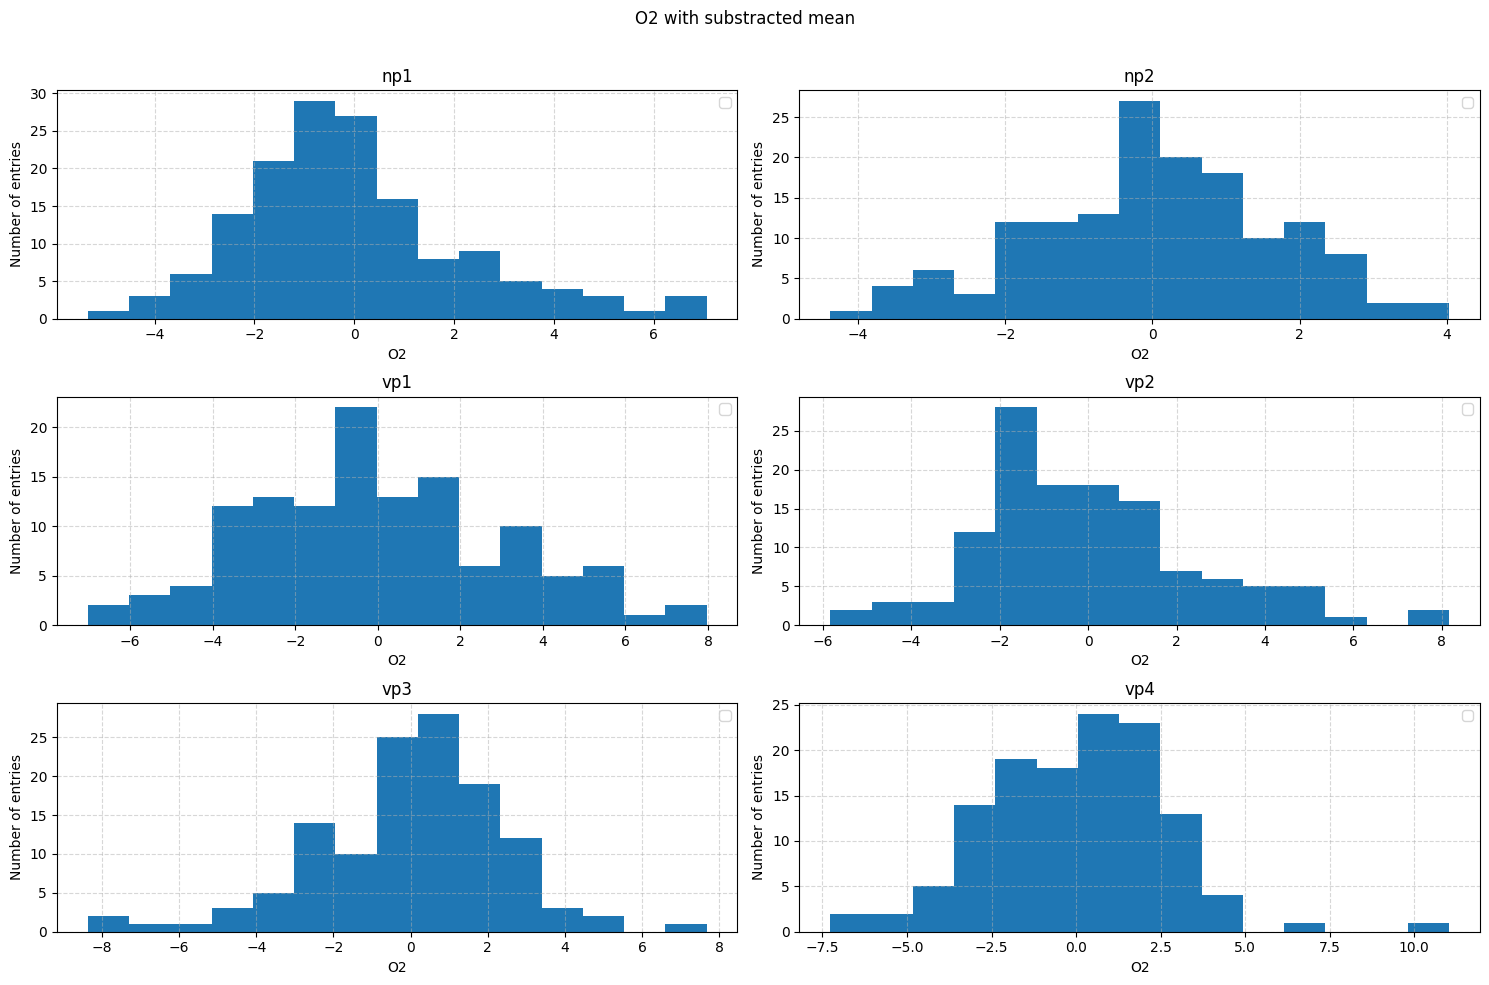

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('O2 with substracted mean')
axes = axes.ravel()
for idx, pond_name in enumerate(pond_names):
    axes[idx].hist(o2_series[pond_name]-o2_series[pond_name].mean(), bins = 15)
    axes[idx].set_title(pond_name)
    axes[idx].set_xlabel('O2')
    axes[idx].set_ylabel('Number of entries')
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [23]:
for pond_name in o2_series.keys():
    ser = o2_series[pond_name]
    jb_test = sm.stats.stattools.jarque_bera(ser)
    print(f'pond: {pond_name}, JB: {jb_test[0]:.1f}, p-value: {jb_test[1]:.2f},'
          f'skew: {jb_test[2]:.1f}, kurtosis: {jb_test[3]:.1f}')

pond: np1, JB: 21.7, p-value: 0.00,skew: 0.8, kurtosis: 3.9
pond: np2, JB: 1.2, p-value: 0.55,skew: -0.2, kurtosis: 2.8
pond: vp1, JB: 2.1, p-value: 0.35,skew: 0.3, kurtosis: 2.6
pond: vp2, JB: 10.4, p-value: 0.01,skew: 0.6, kurtosis: 3.7
pond: vp3, JB: 19.9, p-value: 0.00,skew: -0.5, kurtosis: 4.6
pond: vp4, JB: 18.8, p-value: 0.00,skew: 0.3, kurtosis: 4.8


### Data normality analysis

We can see that O2 data for ponds np2 and vp1 is normally distributed, while for the others it is not.

For each pond, we calculated the following metrics related to oxygen (O2) concentration:

Mean (central tendency)
Standard deviation (variability)
Ratio of standard deviation to mean (relative variability)
These statistics give us insights into the general behavior and variability of oxygen concentrations in each pond. A higher standard deviation to mean ratio indicates higher relative variability.

Jarque-Bera Test for Normality:

The Jarque-Bera test is a statistical test that checks if the data has the skewness and kurtosis of a normal distribution. The test provides a JB statistic, p-value, skewness, and kurtosis value for each dataset.

JB Statistic: Higher values indicate a departure from normality.
p-value: A smaller p-value (typically < 0.05) suggests that the data is not normally distributed.
Skewness: Reflects the data's symmetry. A value of zero means the data is perfectly symmetrical, while positive/negative values indicate skewed distributions.
Kurtosis: Measures the "tailedness" of the distribution. A kurtosis > 3 indicates a leptokurtic distribution (heavy-tailed), and < 3 indicates a platykurtic distribution (light-tailed).
For SARIMA modeling, the assumption is that the residuals (or errors) from the model are normally distributed. The Jarque-Bera test helps verify this assumption.

In [24]:
for pond_name in o2_series.keys():
    ser = o2_series[pond_name]
    
    test = sm.tsa.adfuller(ser)
    critical_values = {key: f"{value:.1f}" for key, value in test[4].items()}
    print(f'{pond_name}: adf {test[0]:.1f}, p-value {test[1]:.2f}, '
          f'Critical values {critical_values}')
    
    if test[0]> test[4]['5%']: 
        print('unit roots, unstationary')
    else:
        print('no unit roots, stationary')

np1: adf -3.4, p-value 0.01, Critical values {'1%': '-3.5', '5%': '-2.9', '10%': '-2.6'}
no unit roots, stationary
np2: adf -3.0, p-value 0.04, Critical values {'1%': '-3.5', '5%': '-2.9', '10%': '-2.6'}
no unit roots, stationary
vp1: adf -2.1, p-value 0.23, Critical values {'1%': '-3.5', '5%': '-2.9', '10%': '-2.6'}
unit roots, unstationary
vp2: adf -4.3, p-value 0.00, Critical values {'1%': '-3.5', '5%': '-2.9', '10%': '-2.6'}
no unit roots, stationary
vp3: adf -4.4, p-value 0.00, Critical values {'1%': '-3.5', '5%': '-2.9', '10%': '-2.6'}
no unit roots, stationary
vp4: adf -2.7, p-value 0.07, Critical values {'1%': '-3.5', '5%': '-2.9', '10%': '-2.6'}
unit roots, unstationary


### Stationarity

In time series analysis, stationarity is a fundamental concept. A time series is said to be stationary if its statistical properties, such as mean, variance, and autocorrelation, are all constant over time. In simpler terms, if you take any segment of the series, its characteristics would be similar to any other segment. This is essential because most time series forecasting methods, including SARIMA, assume or require the series to be stationary.

A non-stationary series, on the other hand, shows patterns, trends, or seasonality. This means that over time, its mean, variance, or behavior might change.

ADF Test

The Augmented Dickey-Fuller (ADF) test is a popular method to test the stationarity of a series. The core idea behind the test is to determine if there's a unit root in the series. If present, it suggests the series is non-stationary. The test returns several statistics, including:

adf - The test statistic. A more negative value indicates stronger evidence against the hypothesis of a unit root.
p-value - This shows the probability of observing the test result if the series has a unit root. A small p-value (typically ≤ 0.05) indicates that the series is likely stationary.
Critical values - These provide thresholds at which we can decide whether or not to reject the hypothesis of a unit root.
Interpretations

np1: The ADF test statistic (-3.4) is more negative than the 5% critical value (-2.9) and the p-value is 0.01, which is below the common alpha level of 0.05. This indicates strong evidence against the unit root hypothesis, suggesting that the series is stationary.

np2: Similar to np1, the test statistic (-3.0) suggests the series is stationary.

vp1: With an ADF statistic of -2.1, which is less negative than the 5% critical value, and a p-value of 0.23, this series appears to have a unit root and is non-stationary.

vp2 & vp3: Both ponds have ADF statistics much more negative than the 5% threshold, indicating stationarity.

vp4: The ADF statistic (-2.7) is closer to the 5% threshold and the p-value is slightly above 0.05. This means there's weaker evidence against the unit root hypothesis, suggesting potential non-stationarity in the series.

### Data transformation

As we have seen, the data have issues with normality and stationarity. Let's addres normality first.

#### Box-Cox Transformation

The Box-Cox transformation is a family of power transformations that are used to stabilize variance and make a dataset more closely follow a normal distribution. It's particularly useful in time series analysis where the stabilization of variance can lead to better forecasting performance.

Let's perform it on the data!

In [25]:
# Box-Cox transformation
o2_boxcox = {}
for pond_name in o2_series.keys():
    ser = o2_series[pond_name]
    sert, lambda_best_fit = boxcox(ser)
    sert = pd.Series(sert, name='o2')
    print(f'Optimal lambda value for pond {pond_name}: {lambda_best_fit:.2f}')
    o2_boxcox[pond_name] = {'data':sert, 'lambda':lambda_best_fit}


Optimal lambda value for pond np1: 0.09
Optimal lambda value for pond np2: 1.22
Optimal lambda value for pond vp1: 0.68
Optimal lambda value for pond vp2: 0.43
Optimal lambda value for pond vp3: 1.35
Optimal lambda value for pond vp4: 0.87


In [26]:
for pond_name in o2_series.keys():
    ser = o2_series[pond_name]
    jb_test = sm.stats.stattools.jarque_bera(ser)
    print(f'before: pond: {pond_name}, JB: {jb_test[0]:.1f}, p-value: {jb_test[1]:.2f},'
          f'skew: {jb_test[2]:.1f}, kurtosis: {jb_test[3]:.1f}')
    
    sert = o2_boxcox[pond_name]['data']
    jb_test = sm.stats.stattools.jarque_bera(sert)
    print(f'after: pond: {pond_name}, JB: {jb_test[0]:.1f}, p-value: {jb_test[1]:.2f},'
          f'skew: {jb_test[2]:.1f}, kurtosis: {jb_test[3]:.1f}\n')
    

before: pond: np1, JB: 21.7, p-value: 0.00,skew: 0.8, kurtosis: 3.9
after: pond: np1, JB: 2.9, p-value: 0.24,skew: 0.0, kurtosis: 3.7

before: pond: np2, JB: 1.2, p-value: 0.55,skew: -0.2, kurtosis: 2.8
after: pond: np2, JB: 0.6, p-value: 0.73,skew: -0.0, kurtosis: 2.7

before: pond: vp1, JB: 2.1, p-value: 0.35,skew: 0.3, kurtosis: 2.6
after: pond: vp1, JB: 0.5, p-value: 0.77,skew: -0.0, kurtosis: 2.7

before: pond: vp2, JB: 10.4, p-value: 0.01,skew: 0.6, kurtosis: 3.7
after: pond: vp2, JB: 1.4, p-value: 0.51,skew: 0.0, kurtosis: 3.5

before: pond: vp3, JB: 19.9, p-value: 0.00,skew: -0.5, kurtosis: 4.6
after: pond: vp3, JB: 7.8, p-value: 0.02,skew: 0.0, kurtosis: 4.2

before: pond: vp4, JB: 18.8, p-value: 0.00,skew: 0.3, kurtosis: 4.8
after: pond: vp4, JB: 11.7, p-value: 0.00,skew: 0.1, kurtosis: 4.5



### Effects of the Box-Cox Transformation
##### np1 Pond:
Before Transformation: The Jarque-Bera test statistic was 21.7 with a p-value of 0.00, indicating significant deviation from normality. The skewness of 0.8 and kurtosis of 3.9 further confirmed this.
After Transformation: The test statistic dropped to 2.9, and the p-value increased to 0.24, suggesting a closer fit to normality. The skewness became almost 0, which is a good indication of symmetry.

##### np2 Pond:
Before: The dataset seemed relatively normal with a JB test statistic of 1.2 and a p-value of 0.55.
After: Even further improvements were seen post-transformation with a decreased JB statistic of 0.6 and increased p-value of 0.73.

##### vp1 Pond:
Before: With a JB statistic of 2.1 and p-value of 0.35, this pond's data was not too far from normality.
After: The transformation slightly improved the normality with a test statistic of 0.5 and a p-value of 0.77.

##### vp2 Pond:
Before: The JB test indicated a deviation from normality with a statistic of 10.4 and p-value of 0.01.
After: Post-transformation, the results were more favorable with a JB statistic of 1.4 and p-value of 0.51.

##### vp3 Pond:
Before: Significant deviation from normality was evident with a JB test statistic of 19.9 and a p-value close to 0.
After: While the transformation improved the distribution to a JB statistic of 7.8, the p-value remained significant at 0.02.

##### vp4 Pond:
Before: The data showed a clear deviation from normality with a JB statistic of 18.8.
After: Despite applying the Box-Cox transformation, the data still showed some deviation from a normal distribution, with a JB statistic of 11.7, although it was reduced compared to the original.

The Box-Cox transformation appeared to improve the normality of most ponds' data, as evidenced by the Jarque-Bera test results. 

### Improving Stationarity

Our dataset captures oxygen levels at two distinct times: in the morning and the evening. Due to the inherent nature of diurnal cycles, oxygen concentration tends to be higher in the evenings. To account for this diurnal seasonality and enhance stationarity, we'll employ a difference-based approach:

By taking the difference between each data point and its corresponding value from two periods (lags) prior, we're essentially subtracting evening data from subsequent evening readings and morning data from subsequent morning readings.

This method can help mitigate the effects of this seasonality and make the dataset more stationary, which is beneficial for time series analysis.

The next cell output will demonstrate this.

In [27]:
for pond_name in o2_series.keys():
    sert = o2_boxcox[pond_name]['data']
    serts = (sert - sert.shift(2)).dropna()
    test = sm.tsa.adfuller(serts)
    critical_values = {key: f"{value:.1f}" for key, value in test[4].items()}
    print(f'{pond_name}: adf {test[0]:.1f}, p-value {test[1]:.2f}, '
          f'Critical values {critical_values}')
    
    if test[0]> test[4]['5%']: 
        print('unit roots, unstationary')
    else:
        print('no unit roots, stationary')


np1: adf -8.4, p-value 0.00, Critical values {'1%': '-3.5', '5%': '-2.9', '10%': '-2.6'}
no unit roots, stationary
np2: adf -6.3, p-value 0.00, Critical values {'1%': '-3.5', '5%': '-2.9', '10%': '-2.6'}
no unit roots, stationary
vp1: adf -3.8, p-value 0.00, Critical values {'1%': '-3.5', '5%': '-2.9', '10%': '-2.6'}
no unit roots, stationary
vp2: adf -4.7, p-value 0.00, Critical values {'1%': '-3.5', '5%': '-2.9', '10%': '-2.6'}
no unit roots, stationary
vp3: adf -4.1, p-value 0.00, Critical values {'1%': '-3.5', '5%': '-2.9', '10%': '-2.6'}
no unit roots, stationary
vp4: adf -4.1, p-value 0.00, Critical values {'1%': '-3.5', '5%': '-2.9', '10%': '-2.6'}
no unit roots, stationary


### Let's take a look at transformed data

Upon applying the aforementioned transformation, we observe that the data now appears to fluctuate consistently around a central value, zero in this case. This is indicative of improved stationarity, wherein the series doesn't exhibit obvious trends or seasonality but instead oscillates around a central tendency. 

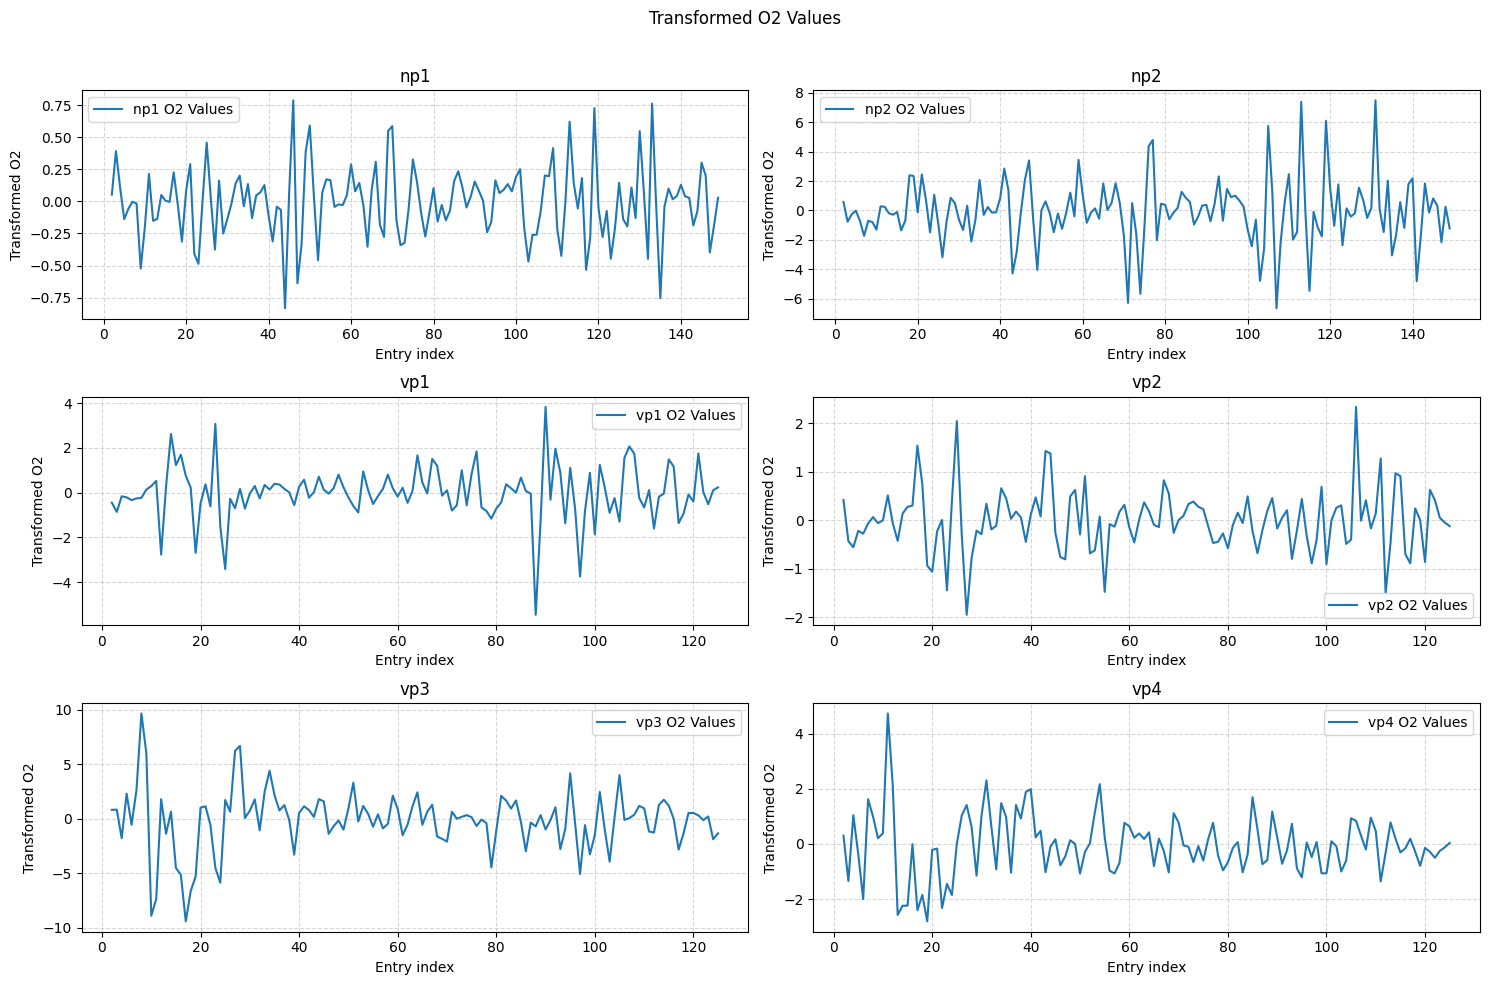

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Transformed O2 Values')
axes = axes.ravel()
for idx, pond_name in enumerate(pond_names):
    sert = o2_boxcox[pond_name]['data']
    serts = (sert - sert.shift(2)).dropna()
    axes[idx].plot(serts, label=f'{pond_name} O2 Values')
    axes[idx].set_title(pond_name)
    axes[idx].set_xlabel('Entry index')
    axes[idx].set_ylabel('Transformed O2')
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

### Analyzing Autocorrelation: ACF and PACF Plots
Before diving deeper into time series modeling, it's pivotal to understand the underlying autocorrelation structure of our dataset. To achieve this, we'll utilize the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) plots.

Why ACF and PACF?
Autocorrelation Function (ACF): This depicts the correlation of the time series with its own lags. It gives us an understanding of how an observation is related to its previous observations.

Partial Autocorrelation Function (PACF): While ACF gives the total correlation, PACF represents the direct correlation between observations at two points in time, discounting the influence of all other observations.

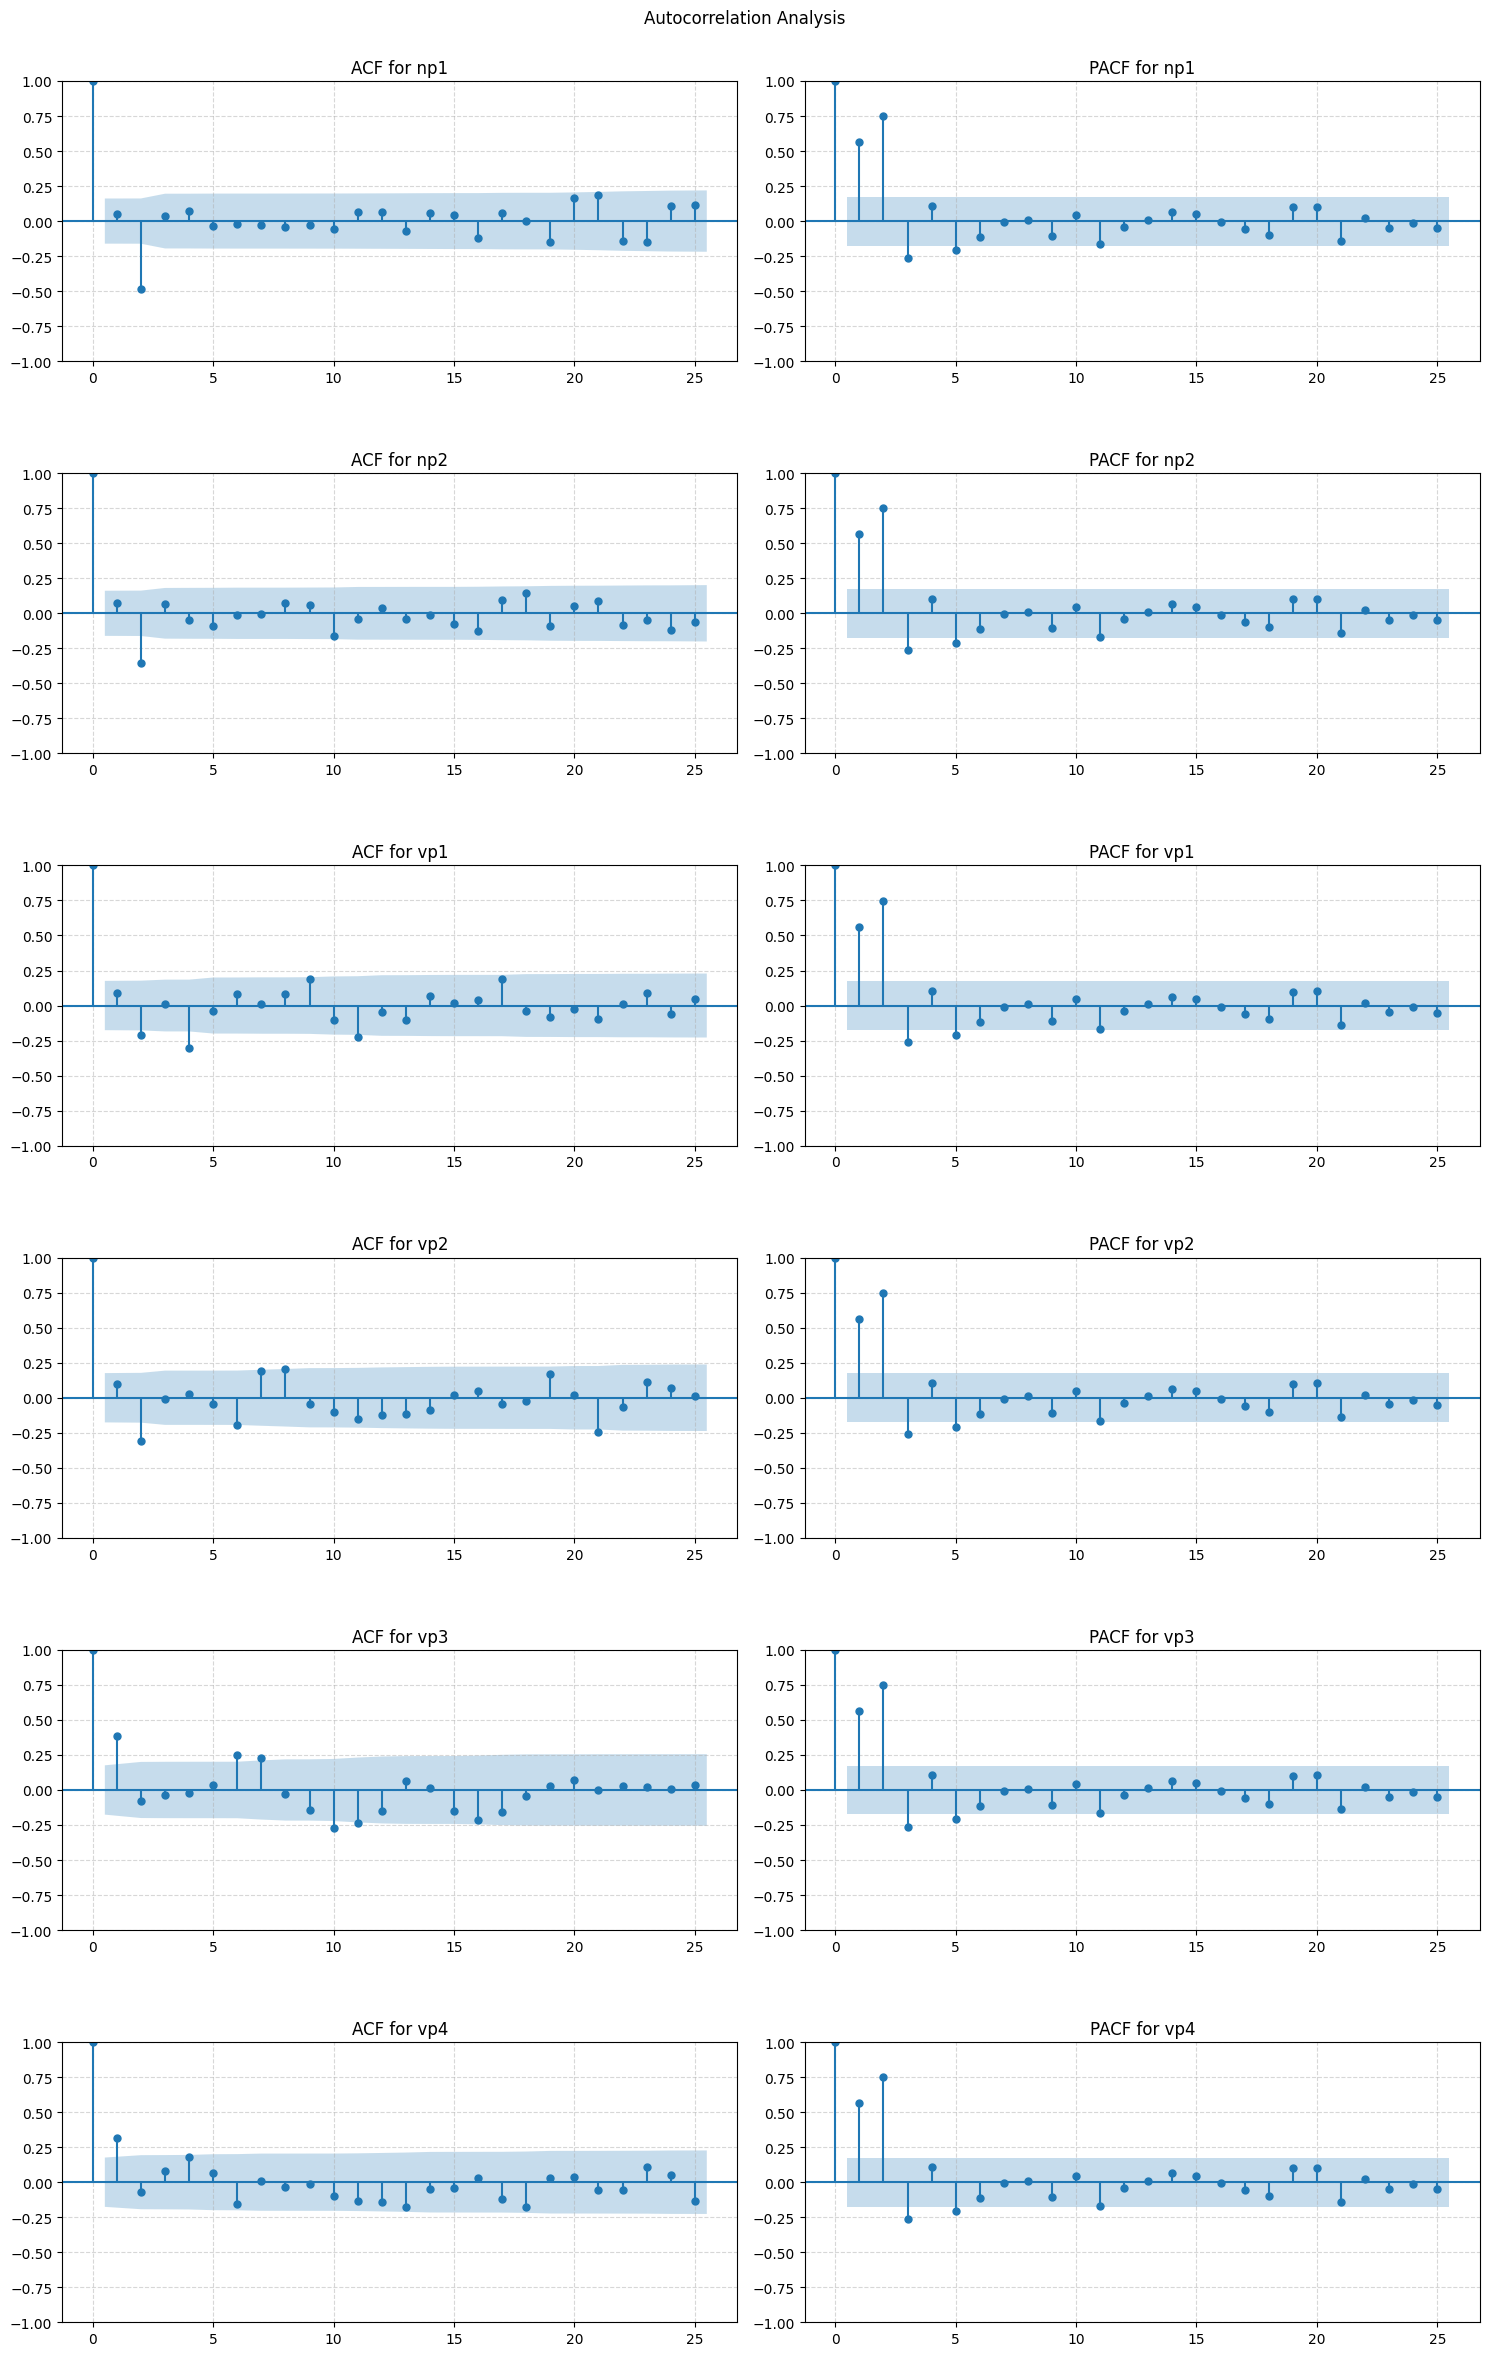

In [29]:
pond_names = list(o2_series.keys())
n_ponds = len(pond_names)

# Adjusting the vertical size based on number of ponds
fig, axes = plt.subplots(n_ponds, 2, figsize=(15, 4*n_ponds))  
fig.suptitle('Autocorrelation Analysis')

for idx, pond_name in enumerate(pond_names):
    sert = o2_boxcox[pond_name]['data']
    serts = (sert - sert.shift(2)).dropna()

    # ACF plot for current pond
    sm.graphics.tsa.plot_acf(serts, lags=25, ax=axes[idx][0])
    axes[idx][0].set_title(f'ACF for {pond_name}')
    axes[idx][0].grid(True, linestyle='--', alpha=0.5)
    
    # PACF plot for current pond
    sm.graphics.tsa.plot_pacf(ser, lags=25, ax=axes[idx][1])
    axes[idx][1].set_title(f'PACF for {pond_name}')
    axes[idx][1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.4)
plt.show()

### SARIMA parameters selection

ACF and PACF graphs are used for SARIMA model parameters setting, more can be found here: https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html

I will use these parameters as starting points for auto_arima parameter search

In [30]:
sarima_params = {}
sarima_params['np1'] = [(1,0,0), (1,1,1,2)]
sarima_params['np2'] = [(1,0,0), (1,1,1,2)]
sarima_params['vp1'] = [(1,0,0), (1,1,2,2)]
sarima_params['vp2'] = [(1,0,0), (1,1,1,2)]
sarima_params['vp3'] = [(3,0,1), (1,1,0,2)]
sarima_params['vp4'] = [(1,0,1), (1,1,0,2)]


In [31]:
! pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [32]:
import pmdarima as pm
models = {}
for pond_name in o2_series.keys():
    data = o2_boxcox[pond_name]['data']

    # Using auto_arima to determine best parameters
    model = pm.auto_arima(data,
                          start_p=sarima_params[pond_name][0][0], 
                          start_q=sarima_params[pond_name][0][2], 
                          start_P=sarima_params[pond_name][1][0], 
                          start_Q=sarima_params[pond_name][1][2],
                          D=1,
                          m=2,
                          seasonal=True, 
                          trace=True, 
                          error_action='ignore', 
                          suppress_warnings=True,
                          stepwise=True)
    models[pond_name] = model

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=-11.053, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=42.618, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=4.300, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=-13.007, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=40.760, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[2] intercept   : AIC=32.369, Time=0.06 sec
 ARIMA(0,0,1)(1,1,1)[2] intercept   : AIC=-11.011, Time=0.11 sec
 ARIMA(0,0,1)(0,1,2)[2] intercept   : AIC=-11.010, Time=0.11 sec
 ARIMA(0,0,1)(1,1,0)[2] intercept   : AIC=3.317, Time=0.10 sec
 ARIMA(0,0,1)(1,1,2)[2] intercept   : AIC=-9.008, Time=0.15 sec
 ARIMA(0,0,0)(0,1,1)[2] intercept   : AIC=-7.039, Time=0.10 sec
 ARIMA(1,0,1)(0,1,1)[2] intercept   : AIC=-14.165, Time=0.15 sec
 ARIMA(1,0,1)(0,1,0)[2] intercept   : AIC=8.833, Time=0.06 sec
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=-12.176, Time=0.26 sec
 ARIMA(1,0,1)(0,1,2)[2] intercept   : AIC=-12.171, Time=0.

In [33]:
for pond_name in models.keys():
    model = models[pond_name]

    # Extracting parameters from the model
    order = model.order
    seasonal_order = model.seasonal_order
    sarima_params[pond_name] = [order, seasonal_order]

    print(f"For pond {pond_name}:")
    print(f"Starting parameters: ARIMA{str(sarima_params[pond_name][0])}"
          f"x{str(sarima_params[pond_name][1])}")
    print(f"Suggested by auto_arima: ARIMA{str(order)}x{str(seasonal_order)}")
    print('-' * 40)

For pond np1:
Starting parameters: ARIMA(1, 0, 1)x(0, 1, 1, 2)
Suggested by auto_arima: ARIMA(1, 0, 1)x(0, 1, 1, 2)
----------------------------------------
For pond np2:
Starting parameters: ARIMA(1, 0, 1)x(1, 1, 1, 2)
Suggested by auto_arima: ARIMA(1, 0, 1)x(1, 1, 1, 2)
----------------------------------------
For pond vp1:
Starting parameters: ARIMA(1, 0, 1)x(0, 1, 2, 2)
Suggested by auto_arima: ARIMA(1, 0, 1)x(0, 1, 2, 2)
----------------------------------------
For pond vp2:
Starting parameters: ARIMA(1, 0, 0)x(0, 1, 1, 2)
Suggested by auto_arima: ARIMA(1, 0, 0)x(0, 1, 1, 2)
----------------------------------------
For pond vp3:
Starting parameters: ARIMA(0, 0, 1)x(0, 1, 0, 2)
Suggested by auto_arima: ARIMA(0, 0, 1)x(0, 1, 0, 2)
----------------------------------------
For pond vp4:
Starting parameters: ARIMA(1, 0, 1)x(0, 1, 0, 2)
Suggested by auto_arima: ARIMA(1, 0, 1)x(0, 1, 0, 2)
----------------------------------------


### Analysing model perforamnce

This code will show the ACF and PACF plots for the residuals of each pond, giving insights into the remaining autocorrelations in the residuals. If the model is fitting well, most of the bars in the ACF and PACF plots should be within the blue confidence intervals, indicating that the residuals are white noise.

As we can see, residuals still show signs of autocorrelation, so I have to consider either adding external regressors (exogenous variables) to the SARIMA model or exploring other time series techniques.

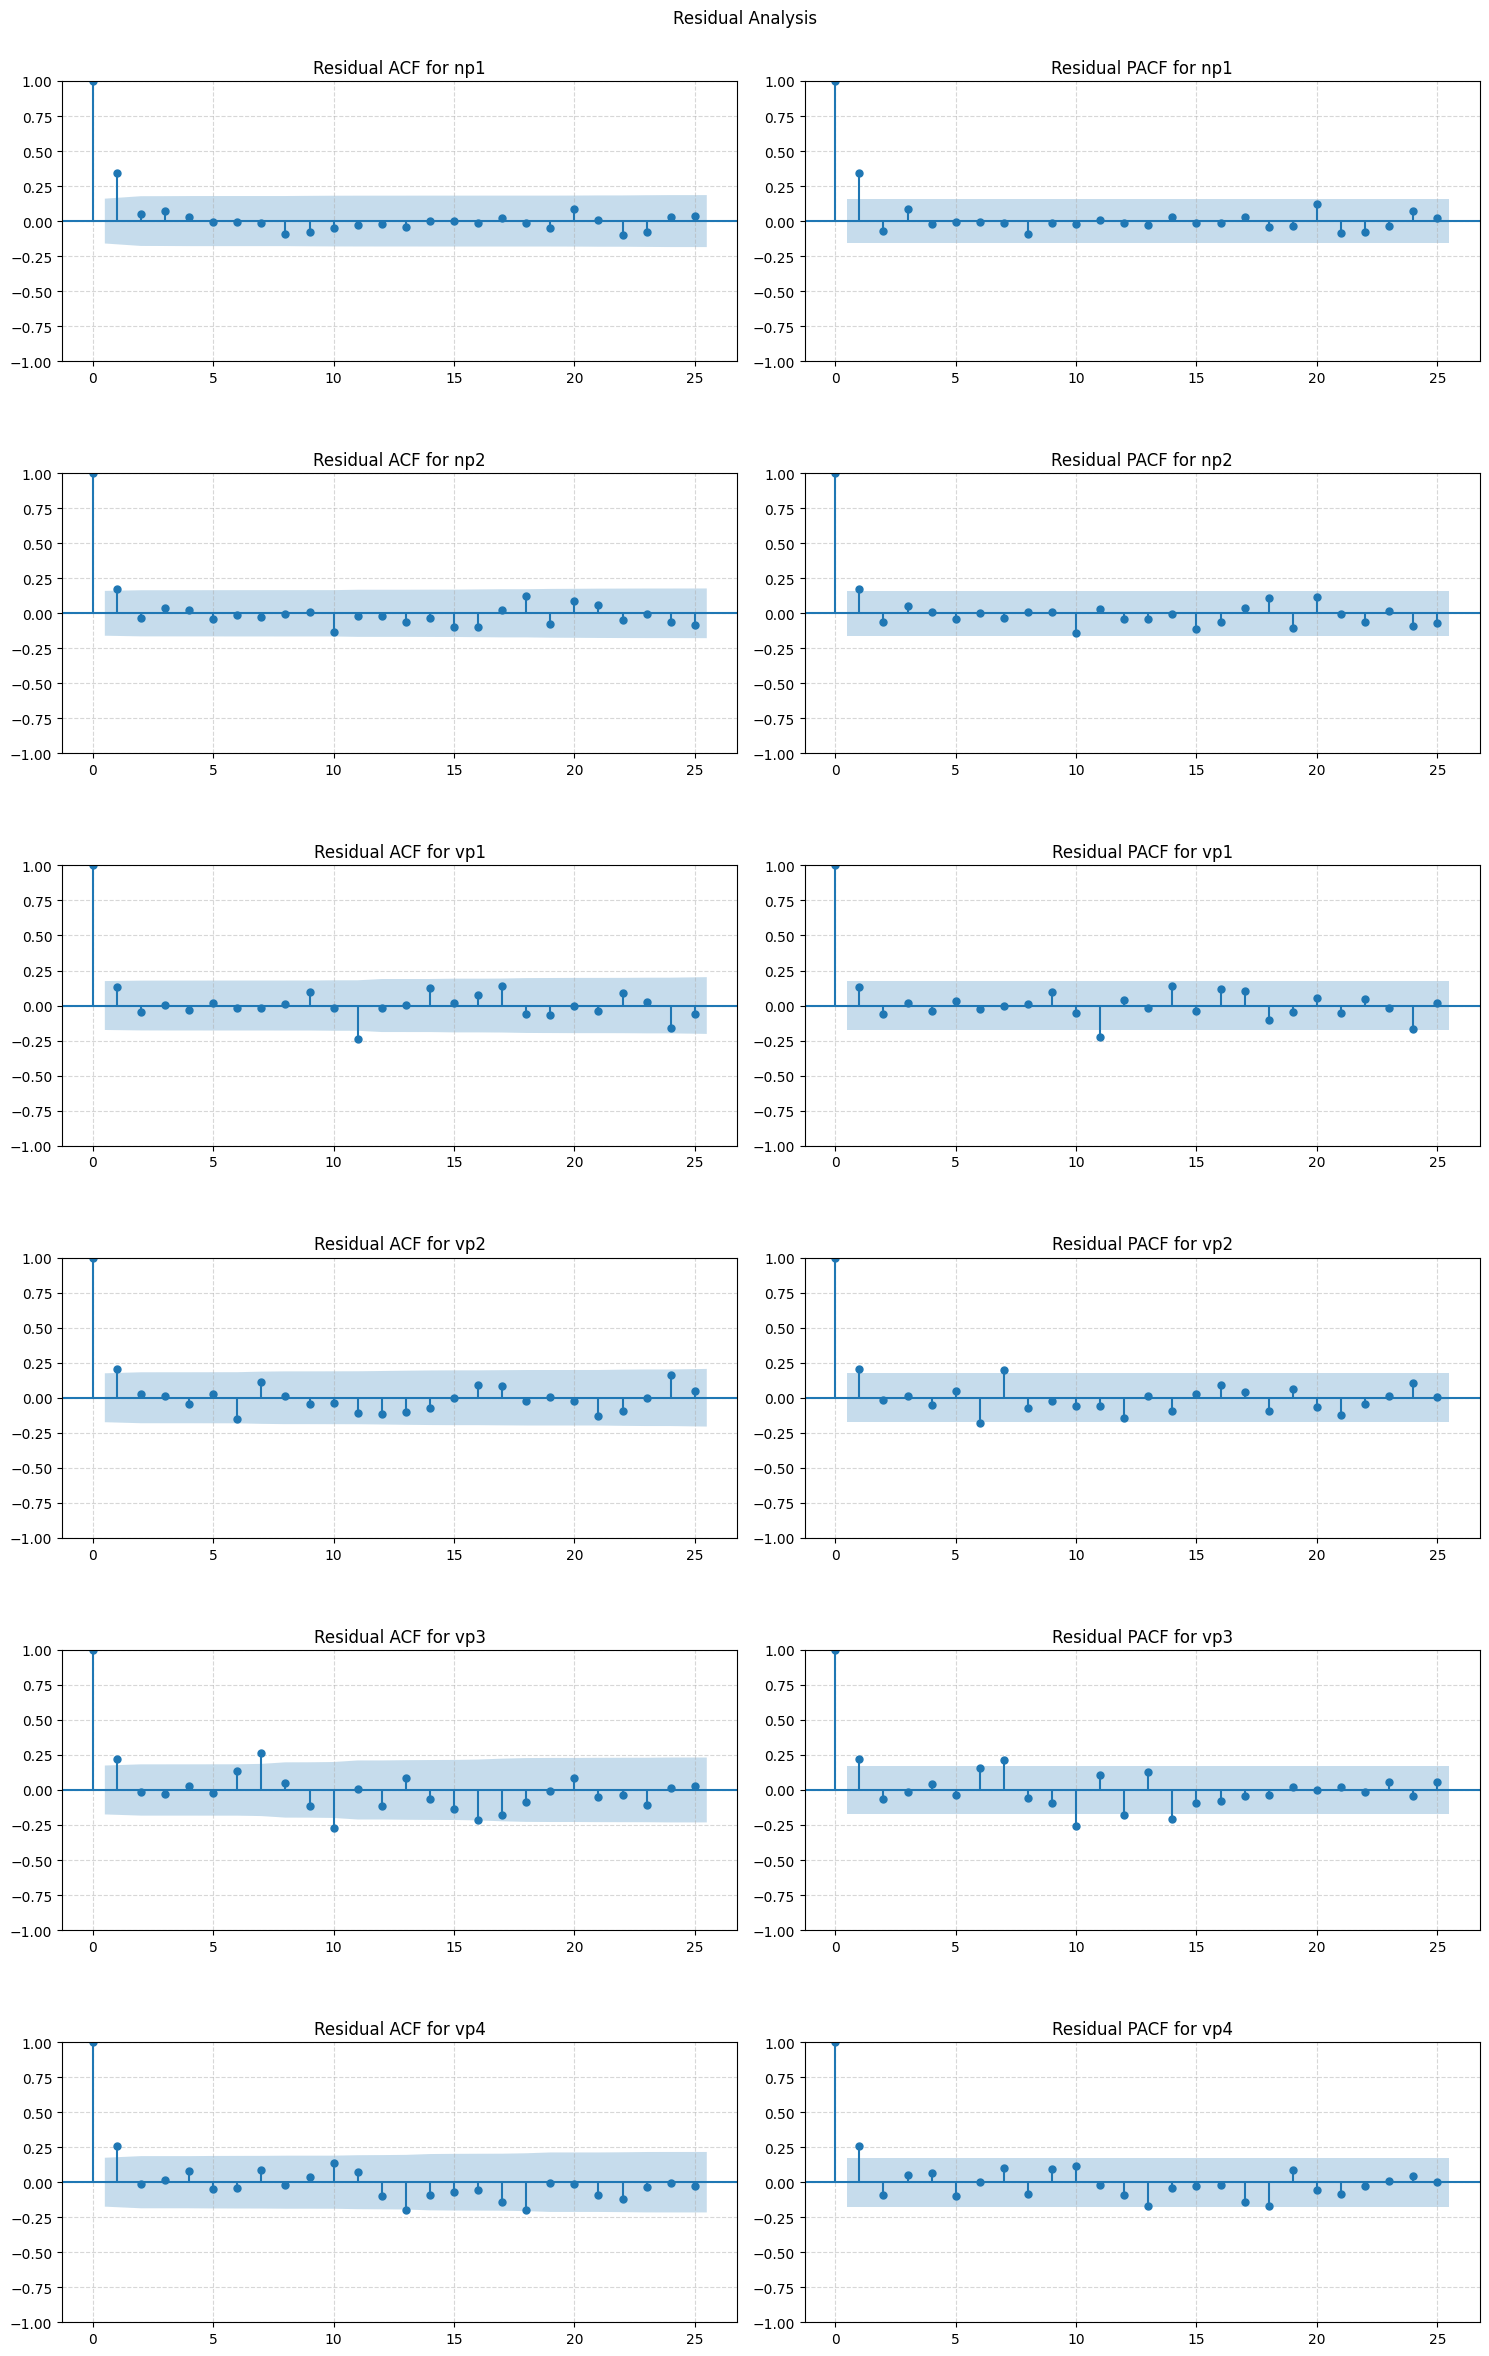

In [34]:
pond_names = list(o2_series.keys())
n_ponds = len(pond_names)

# Adjusting the vertical size based on number of ponds
fig, axes = plt.subplots(n_ponds, 2, figsize=(15, 4*n_ponds))  
fig.suptitle('Residual Analysis')

for idx, pond_name in enumerate(pond_names):
    model = models[pond_name]
    residuals = model.resid()
    # ACF plot for residuals of current pond
    sm.graphics.tsa.plot_acf(residuals, lags=25, ax=axes[idx][0])
    axes[idx][0].set_title(f'Residual ACF for {pond_name}')
    axes[idx][0].grid(True, linestyle='--', alpha=0.5)
    
    # PACF plot for residuals of current pond
    sm.graphics.tsa.plot_pacf(residuals, lags=25, ax=axes[idx][1])
    axes[idx][1].set_title(f'Residual PACF for {pond_name}')
    axes[idx][1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.4)
plt.show()

### Ljung-Box Test on Residuals
The Ljung-Box test is applied to determine the presence of autocorrelation in a time series, which makes it especially useful when evaluating residuals following modeling. 

Residuals ideally should exhibit characteristics of white noise, meaning they should be independently and identically distributed. When the Ljung-Box test is applied to residuals, it aids in validating this white noise assumption. If there's significant autocorrelation found in the residuals, it could indicate that certain patterns in the data were not captured by the model, suggesting potential areas of improvement. 

Conversely, residuals without detectable autocorrelation provide assurance that the model has effectively encapsulated the major underlying dynamics of the data, hinting at the model's predictive robustness.

In [35]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Create an empty DataFrame with desired columns
results_df = pd.DataFrame(columns=["Ljung-Box Test", "P-value", "Residual Count", "Residual Mean", "Residual Std"])

for pond_name in o2_series.keys():
    model = models[pond_name]
    
    # Extracting residuals
    residuals = model.resid()

    # Ljung-Box test
    lb_test_df = acorr_ljungbox(residuals, lags=[10], return_df=True)
    
    # Descriptive statistics for residuals
    res_desc = residuals.describe()
    
    # Append results to DataFrame, formatted as desired
    results_df.loc[pond_name] = [
        f"{lb_test_df['lb_stat'].iloc[0]:.3f}",
        f"{lb_test_df['lb_pvalue'].iloc[0]:.3f}",
        int(res_desc['count']),
        f"{res_desc['mean']:.3f}",
        f"{res_desc['std']:.3f}"
    ]

# Display the DataFrame
print(results_df)

    Ljung-Box Test P-value  Residual Count Residual Mean Residual Std
np1         21.923   0.016             150         0.022        0.384
np2          8.172   0.612             150        -0.039        2.248
vp1          4.254   0.935             126         0.078        1.236
vp2         11.353   0.331             126         0.057        0.756
vp3         30.947   0.001             126         0.195        3.262
vp4         14.360   0.157             126         0.081        1.406


### Summary of Model Performance and Initial Data Normality on Ponds

#### np1
Initial Normality: Moderate (JB: 21.7, p-value: 0.00)
Stationarity: No unit roots, stationary (ADF: -3.4, p-value: 0.01)
Ljung-Box Test: Some potential autocorrelation (P-value: 0.0155)
Assessment:
Initial data for np1 wasn't particularly normal but was stationary. After modeling, potential autocorrelation in residuals was observed.

#### np2
Initial Normality: High (JB: 1.2, p-value: 0.55)
Stationarity: No unit roots, stationary (ADF: -3.0, p-value: 0.04)
Ljung-Box Test: Residuals are white noise (P-value: 0.612)
Assessment:
np2 had relatively normal initial data that was stationary. The model performed well with residuals resembling white noise.

#### vp1
Initial Normality: High (JB: 2.1, p-value: 0.35)
Stationarity: Unit roots, unstationary (ADF: -2.1, p-value: 0.23)
Ljung-Box Test: Residuals are white noise (P-value: 0.9351)
Assessment:
Initial data for vp1 was fairly normal but not stationary. However, the model showed good performance with residuals appearing as white noise.

#### vp2
Initial Normality: Moderate (JB: 10.4, p-value: 0.01)
Stationarity: No unit roots, stationary (ADF: -4.3, p-value: 0.00)
Ljung-Box Test: Residuals might be white noise (P-value: 0.3307)
Assessment:
vp2's initial data had some deviations from normality but was stationary. Post modeling, the residuals lean towards white noise.

#### vp3
Initial Normality: Low (JB: 19.9, p-value: 0.00)
Stationarity: No unit roots, stationary (ADF: -4.4, p-value: 0.00)
Ljung-Box Test: Some potential autocorrelation (P-value: 0.0006)
Assessment:
vp3 had less normal initial data, but it was stationary. The model's residuals indicate potential autocorrelation, suggesting suboptimal performance.

#### vp4
Initial Normality: Low (JB: 18.8, p-value: 0.00)
Stationarity: Unit roots, unstationary (ADF: -2.7, p-value: 0.07)
Ljung-Box Test: Residuals might be white noise (P-value: 0.1572)
Assessment:
Despite vp4's initial data not being very normal and being non-stationary, the model's residuals seem to be close to white noise.

#### Overall Insights:
Ponds with High Initial Normality and Stationarity (np2): This pond showed good model performance with residuals resembling white noise.

Ponds with Moderate to Low Initial Normality but Stationary (np1, vp2, vp3): The correlation between initial data normality and model performance is mixed. While some (vp2) managed decent results, others (np1, vp3) showed potential issues like autocorrelation.

Ponds with High Initial Normality but Non-stationary (vp1, vp4): Despite having non-stationary data, these ponds' models managed decent results.

In conclusion, while there's a trend that ponds with initially more normal and stationary data tend to have models with better residuals, it's not strictly the case for all ponds. Stationarity, in conjunction with normality, plays a significant role in model performance.

### Rolling-window validation

The below code block uses a rolling-window validation technique to forecast time series data for different ponds. At its core, this method involves training a model on a fixed-size window of historical data and then predicting the next value. After the prediction is made, the window moves one step forward in the time series, and the model is retrained to predict the next value. This process rolls on until predictions are generated for the entire series. Such an approach offers a dynamic way to assess how well the model might perform in a real-world scenario where it's constantly updated with new observations. The code also considers Box-Cox transformations, ensuring predictions are on the original data scale, and measures forecast accuracy using the Root Mean Squared Error (RMSE).

In [36]:
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
    
preds = {}
window = 30

for pond_name in o2_series.keys():
    ser = o2_series[pond_name]
    sert = o2_boxcox[pond_name]['data']
    lambda_best_fit = o2_boxcox[pond_name]['lambda']
    
    # Rolling window validation
    predictions = []

    test = list(ser[window:])

    for i in range(len(sert) - window + 1):
        train_temp = sert[i: i + window]
        # Will use SARIMAX from statsmodels for a change
        model = SARIMAX(train_temp,
                        order=sarima_params[pond_name][0],
                        seasonal_order=sarima_params[pond_name][1])
        model_fit = model.fit(disp=-1, maxiter=400)
        yhat = model_fit.forecast(steps=1).iloc[0]
        yhat_inv = inv_boxcox(yhat, lambda_best_fit)
        predictions.append(yhat_inv)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions[:-1]))
    r2 = r2_score(test, predictions[:-1])
    print(f'pond: {pond_name}, RMSE: {rmse:.3f}, R2: {r2:.2f}')
    
    preds[pond_name] = [None]*(window) + predictions

NameError: name 'np' is not defined

### Model Insights with Rolling Window Results:
#### np1
Initial State: Moderate normality and stationary.

Ljung-Box Test: Potential autocorrelation.

Rolling Window RMSE: 1.744, R2: 0.26 

Assessment: Initial data for np1 had deviations from normality but was stationary. Model performance, based on RMSE, suggests potential room for improvement.
#### np2
Initial State: High normality and stationary.

Ljung-Box Test: Residuals are white noise.

Rolling Window RMSE: 1.512, R2: 0.12

Assessment: The model for np2, which had relatively normal initial data, showed a relatively good performance based on its RMSE. However, R2 implies that the model explains only 12% of the data.
#### vp1
Initial State: High normality but non-stationary.

Ljung-Box Test: Residuals are white noise.

Rolling Window RMSE: 2.091, R2: 0.56
The warning message suggests that the optimization procedure for MLE did not converge. The model couldn't find a set of parameters that best fit the data within the specified number of iterations. The parameter estimates for your model might not be reliable.

Assessment: The model's RMSE for vp1 is higher compared to np1 and np2, indicating potential model inefficiencies despite the residuals appearing as white noise and R2 is as high as 0.56.
#### vp2
Initial State: Moderate normality and stationary.

Ljung-Box Test: Residuals might be white noise.

Rolling Window RMSE: 1.972, R2: 0.40

Assessment: vp2's model exhibited acceptible performance, indicated by its RMSE, despite its initial data showing some deviations from normality.
#### vp3
Initial State: Low normality but stationary.

Ljung-Box Test: Some potential autocorrelation.

Rolling Window RMSE: 0.779, R2: 0.75

Assessment: Despite having less normal initial data, vp3's model showed good performance based on its low RMSE and high R2, although the residuals indicate potential autocorrelation.
#### vp4
Initial State: Low normality and non-stationary.

Ljung-Box Test: Residuals might be white noise.

Rolling Window RMSE: 0.992, R2: 0.74

Assessment: vp4's model, with a decent RMSE and R2 score, demonstrates the model's ability to capture the dynamics of the time series data, even with less normal and non-stationary initial conditions.

#### Overall Insights:
There's a discernible relationship between the initial conditions of the data (normality and stationarity) and the model's performance as assessed by RMSE. Generally, ponds with initially more normal and stationary data tend to have models with better residuals, but the rolling window technique does introduce some nuances to this observation. Specifically, some ponds, despite having less than ideal initial conditions, manage to produce models with decent RMSE values. On the flip side, certain ponds with good initial conditions might have higher RMSE values, suggesting potential model inefficiencies or challenges in predicting more complex patterns in the data.

### Predicted (red) vs actual O2 data (blue)

In [ ]:
# Creating a 2x3 grid for the ponds (2 rows, 3 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle("Walk-forward validation: Predicted vs Actual values")

# Flatten the axes array for easier indexing
axes = axes.ravel()

for idx, pond_name in enumerate(pond_names):
    # Plotting the O2 values for each pond
    axes[idx].plot(o2_series[pond_name], label=f'{pond_name} Actual values')
    axes[idx].plot(preds[pond_name], color='red', label="Predicted values")
    axes[idx].set_title(pond_name)
    axes[idx].set_xlabel('Entry index')
    axes[idx].set_ylabel('O2')
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.5)

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust the top spacing so that the main title doesn't overlap
plt.show()

In [ ]:
real_df = pd.DataFrame()
pred_df = pd.DataFrame()

max_length = 150  

for pond in pond_names:
    actual_len = len(o2_series[pond])
    preds_len = len(preds[pond][:-1])  
    
    # If the length is less than the maximum, prepend with NaNs
    if actual_len < max_length:
        nan_pad = pd.Series(data = ([np.nan] * (max_length - actual_len)), name='o2')
        real_df[pond] = pd.concat([nan_pad, o2_series[pond]], ignore_index = True)
        pred_df[pond] = pd.concat(
            [nan_pad, pd.Series(data =preds[pond][:-1], name='o2')],
            ignore_index = True
        )
    else:
        real_df[pond] = o2_series[pond]
        pred_df[pond] = preds[pond][:-1]

real_df.to_csv('SARIMA_data')
pred_df.to_csv('SARIMA_predictions')